In [1]:
import tensorflow as tf
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.8.0


In [356]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns
import os
import pickle

# Import data

In [3]:
# Tureky soil samples are the soils starting with 'no' 1000 or above
data = pd.read_csv('data.csv') \
            .drop('hhpa', axis=1)
print(data.shape) 
data.head()

(20383, 9)


,fold,no,clay,silt,sand,BD,omc,pF,VWC
0,1,55,32.6,43.3,24.1,1.14,4.50,0.841595,55.8
1,1,97,19.8,67.0,13.2,1.14,3.56,1.069393,48.7
2,1,166,27.7,41.6,30.7,1.15,3.00,2.057260,39.4
3,1,1015,45.7,30.4,24.0,0.85,0.49,1.360000,62.0
4,1,1066,13.5,25.5,61.0,1.23,1.27,2.690000,25.0


## EDA

In [ ]:
data.groupby('fold').count()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 10))
sns.boxplot(data=data.iloc[:, 2:])
plt.show()

In [ ]:
data.describe()

In [ ]:
sns.reset_orig()
plt.figure(figsize=(18,12))
corr = data.iloc[:, 2:].corr()
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

sns.heatmap(corr, annot = True, mask=matrix,cmap="YlGnBu")
plt.show()

In [ ]:
# sns.pairplot(data.iloc[:, 2:]);

# Neural Network Model

In [4]:
from keras_tuner.tuners import RandomSearch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
## Make directory for storing saved models
# os.makedirs('models')

## Build Models

### Define the bagging function

In [6]:
def bagging(rawdata):
    """Take bootstrap samples - sampling with replacement.
    Similar to GroupKFold or StratifiedGroupKFold but these functions require 
    atleast 2 number of splits"""
    ###generator random sample id with replacement 
    # m,n = rawdata.shape
    idx = pd.DataFrame(rawdata[['no']])
    idx_rmdup = idx.drop_duplicates()
    length = len(idx_rmdup)
    samples = idx_rmdup.sample(length, replace= True)

    # changing the sample id into one dimensional list in order to label sampleid in idx 
    samples_list = samples.transpose().values.tolist()[0] 

    ###going through the sampleid dataframe and marking the sample as training or validation dataset. 
    idx['labels'] = ['training' if x in samples_list else 'validation'  for x in idx['no'] ]
    rawdata_con = pd.concat([rawdata,idx['labels']],axis = 1)

    ###spliting rawdata into training and validation based on label column 
    grouped_rawdata = rawdata_con.groupby('labels')
    training = grouped_rawdata.get_group('training')
    validation = grouped_rawdata.get_group('validation')
    return training,validation

### `build_model` function

In [7]:
def build_model(hp):
    """Build and compile the NN model"""
    model = tf.keras.Sequential([
       tf.keras.layers.Dense(
                        units=hp.Int('units',
                        min_value=2,
                        max_value=14,
                        step=1), activation= "relu"),
        tf.keras.layers.Dense(units=1)])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='mse',
            metrics=['mae'])
    return model

### Bootstrap (finding and fitting best models)

In [ ]:
best_parms = {}

iteration = 100
for bb in range(79,iteration):
    training, validation = bagging(data)
    X_train = training.iloc[:,2:-2]
    y_train = training.iloc[:,-2]/100
    X_valid = validation.iloc[:,2:-2]
    y_valid = validation.iloc[:,-2]/100

    scaler = MinMaxScaler() 
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)

    tuner = RandomSearch(
        build_model,    
        objective='val_loss',
        max_trials=3,
        executions_per_trial=1,
        overwrite=True,
        directory='project',
        project_name='HPtuning_'+str(bb))

    early_stop = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3,
                            restore_best_weights=True)]

    tuner.search(X_train, y_train,
                epochs=100,
                validation_data=(X_valid, y_valid),
                callbacks=early_stop,
                verbose=2)

    best_hps = tuner.get_best_hyperparameters(2)
    model = build_model(best_hps[0])

    print(f"Fitting the best model for iteration {bb+1}......." "\n"
            f"Training Size = {len(training)}, validation Size = {len(validation)}" "\n"
            f"Unique soils in Training = {len(training.no.unique())}" "\n"
            f"Unique soils in Validation = {len(validation.no.unique())}")
    # use `model.fit()` here to train and save the best model from `tuner.search`

    best_parms[bb] = tuner.get_best_hyperparameters(num_trials=1)

    callback = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10,
                                restore_best_weights=True),
                    tf.keras.callbacks.ModelCheckpoint(filepath="models/ANN_all"+str(bb)+".h5",
                                monitor="val_loss",
                                save_best_only=True)]

    model.fit(X_train, y_train,
                batch_size = 32, epochs = 1000,
                callbacks=callback,
                validation_data=(X_valid, y_valid),
                verbose=0)
    print("Done")

In [ ]:
with open('best_hyperParameters.pkl', 'wb') as handle:
    pickle.dump(best_parms, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

# Predict

## Import data and apply Scaler

In [ ]:
## Save Scaler
# scaler = MinMaxScaler() 
# scaler.fit_transform(data.iloc[:,2:-1])
# pickle.dump(scaler, open('annAll_scaler.pkl', 'wb'))

In [384]:
scaler = pickle.load(open('annAll_scaler.pkl', 'rb'))

In [390]:
pF = pd.Series(np.arange(-1, 6, 0.05), name='pF')

soil_df = data[data["no"]==1062]
df = pd.concat([soil_df.iloc[:,2:-2].drop_duplicates()]*len(pF), ignore_index=True)
test = pd.concat([df,pF], axis=1)

X_test = scaler.transform(test)

## Define `wettodry` and `drytowet` functions

In [386]:
def wettodry(vwc):
    vwc = [0 if i < 0 else i for i in vwc]
    w2d = [vwc[0]]
    for idx in range(1, len(vwc)):
        if vwc[idx] < w2d[idx-1]:
            w2d.append(vwc[idx])
        else:
            w2d.append(w2d[idx-1])
    return w2d

def drytowet(vwc):
    vwc = [0 if i < 0 else i for i in vwc]
    rslt_reverse = vwc[::-1]
    d2w = [rslt_reverse[0]]
    for idx in range(1, len(vwc)):
        if rslt_reverse[idx] > d2w[idx-1]:
            d2w.append(rslt_reverse[idx])
        else:
            d2w.append(d2w[idx-1])
    return d2w[::-1]

## `bag_predict`
and measure Mean and standard deviations

In [387]:
def bag_predict(models):
    bag_pred = pd.DataFrame()
    for ann in models:
        # print(ann)
        ann_all = tf.keras.models.load_model(ann)
        y_pred = ann_all.predict(X_test)
        w2d = wettodry(y_pred.ravel().tolist())
        d2w = drytowet(y_pred.ravel().tolist())
        print(w2d==d2w)
        pred_list = [(g + h) / 2 for g, h in zip(w2d, d2w)]
        bag_pred[ann[ann.find('ANN'):-3]] = pd.Series(pred_list)

    mean_vwc = bag_pred.mean(axis=1)
    std_vwc = bag_pred.std(axis=1)
    return mean_vwc, std_vwc

## Apply `bag_predict`

In [ ]:
models = ['models/ANN_all'+ str(i) + '.h5' for i in range(100)]
mean_vwc, std_vwc = bag_predict(models)

## Plot

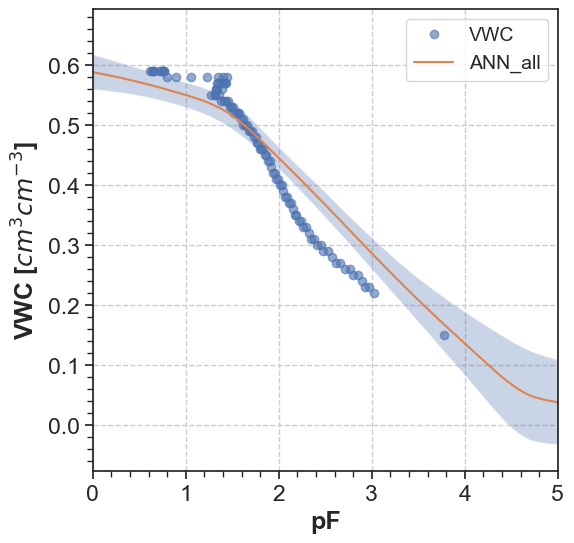

In [392]:
sns.set(font_scale=1.5, style="ticks")
fig, ax = plt.subplots(figsize = (6,6))
ax.plot(soil_df['pF'], soil_df['VWC']/100, 'o', alpha=0.6, label = 'VWC')
ax.plot(pF, mean_vwc, '-', label = 'ANN_all')
ax.fill_between(pF, mean_vwc+std_vwc, mean_vwc-std_vwc, alpha=0.3)
ax.set_xlim(0,5)
ax.legend(prop={'size': 14})
ax.grid(True,linestyle='--')

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(.1))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.set_xlabel('pF',size = 18, weight = 'bold')
ax.set_ylabel('VWC'r' [$cm^3 cm^{-3}$]',size = 18, weight = 'bold')
plt.show()

# Miscellaneous

In [ ]:
# import plotly.graph_objects as go
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=soil_df["pF"], y=soil_df["VWC"]/100,
#                         mode='markers',
#                         name='VWC'))
# fig.add_trace(go.Scatter(x=pF, y=mean_vwc,
#                         mode='lines',
#                         name='ANN_all'))
# fig.show()